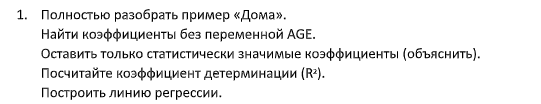

In [2]:
import pandas as pd
import numpy as np
import os

In [1]:
os.chdir("/Users/kruto/Desktop/")
home = pd.read_csv('Home_prices.txt', sep="\t", header = 0, index_col=False)

In [3]:
home.head()


,PRICE,SQFT,AGE,FEATS,NE,CUST,COR,TAX
0,2050,2650,13,7,1,1,0,1639
1,2080,2600,-9999,4,1,1,0,1088
2,2150,2664,6,5,1,1,0,1193
3,2150,2921,3,6,1,1,0,1635
4,1999,2580,4,4,1,1,0,1732


In [4]:
print('Rows in the dataframe: {0} '.format(len(home)))
print('Rows without NAN: {0}'.format(len(home.dropna(how='any'))))

Rows in the dataframe: 117 
Rows without NAN: 117


In [5]:
home.apply(lambda x: sum(x.isnull()), axis=0)

PRICE    0
SQFT     0
AGE      0
FEATS    0
NE       0
CUST     0
COR      0
TAX      0
dtype: int64

In [6]:
import collections, numpy
a = np.array(home['AGE'].isnull())
print(collections.Counter(a))


b = np.array(home['AGE'])
print(collections.Counter(b))
# -999 - 49

Counter({False: 117})
Counter({-9999: 49, 4: 8, 6: 7, 7: 6, 15: 5, 5: 4, 13: 3, 16: 3, 17: 3, 3: 2, 1: 2, 8: 2, 14: 2, 28: 2, 25: 2, 40: 2, 2: 1, 18: 1, 53: 1, 30: 1, 41: 1, 46: 1, 43: 1, 23: 1, 26: 1, 34: 1, 20: 1, 19: 1, 22: 1, 45: 1, 9: 1})


In [7]:
##  отрицательные на nan
home = home.replace(-9999, np.nan)

In [8]:
home.apply(lambda x: sum(x.isnull()), axis=0)

PRICE     0
SQFT      0
AGE      49
FEATS     0
NE        0
CUST      0
COR       0
TAX      10
dtype: int64

In [9]:
del home['AGE']

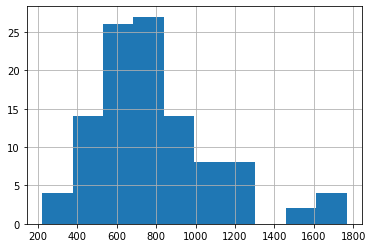

In [10]:
# починка tax
home['TAX'].hist()
# заменяем пропуски на среднее значение
home['TAX'] = home['TAX'].fillna(home['TAX'].mean())

In [11]:
print(len(home.dropna()), len(home))

117 117


# Построение модели

In [12]:
from sklearn.linear_model import LinearRegression

In [13]:
X = home.drop('PRICE', axis=1)
y = home['PRICE']

In [14]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [15]:
# Считаем качество модели (коэффициент  𝑅2 ).
print('R^2: {0}'.format(model.score(X, y)))

R^2: 0.8022436103807493


In [16]:
#Выведем регрессионные коэффициенты от метода model.coef_ и свободный член от метода model.intercept_.
coef = pd.DataFrame(zip(['intercept'] + X.columns.tolist(), [model.intercept_] + model.coef_.tolist()),
                    columns=['predictor', 'coef'])
coef

,predictor,coef
0,intercept,83.175919
1,SQFT,0.291978
2,FEATS,12.176743
3,NE,8.011604
4,CUST,133.014342
5,COR,-65.800841
6,TAX,0.541942


In [17]:
# определение статистической значимости регрессионных коэффициентов

from scipy import stats

def regression_coef(model, X, y):
    coef = pd.DataFrame(zip(['intercept'] + X.columns.tolist(), [model.intercept_] + model.coef_.tolist()),
                    columns=['predictor', 'coef'])
    X1 = np.append(np.ones((len(X),1)), X, axis=1)
    b = np.append(model.intercept_, model.coef_)
    MSE = np.sum((model.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
    var_b = MSE * (np.linalg.inv(np.dot(X1.T, X1)).diagonal())
    sd_b = np.sqrt(var_b)
    t = b / sd_b
    coef['pvalue'] = [2 * (1 - stats.t.cdf(np.abs(i), (len(X1) - 1))) for i in t]
    return coef
regression_coef(model, X, y)

,predictor,coef,pvalue
0,intercept,83.175919,1.895059e-01
1,SQFT,0.291978,2.580075e-06
2,FEATS,12.176743,3.419172e-01
3,NE,8.011604,8.190403e-01
4,CUST,133.014342,3.454095e-03
5,COR,-65.800841,1.168611e-01
6,TAX,0.541942,4.972770e-07


          PRICE      SQFT     FEATS        NE      CUST       COR       TAX
PRICE  1.000000  0.844795  0.420272  0.167840  0.555292 -0.079293  0.844889
SQFT   0.844795  1.000000  0.394925  0.145030  0.520102  0.040528  0.832674
FEATS  0.420272  0.394925  1.000000  0.190016  0.241964 -0.041547  0.419473
NE     0.167840  0.145030  0.190016  1.000000  0.043033 -0.077336  0.189230
CUST   0.555292  0.520102  0.241964  0.043033  1.000000 -0.003994  0.444906
COR   -0.079293  0.040528 -0.041547 -0.077336 -0.003994  1.000000 -0.058329
TAX    0.844889  0.832674  0.419473  0.189230  0.444906 -0.058329  1.000000


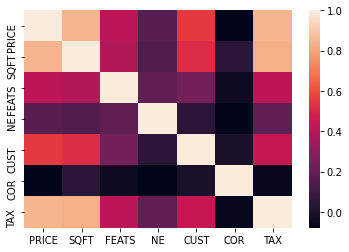

In [18]:
import seaborn as sns
print(home.corr())
sns.heatmap(home.corr())

In [19]:
# налоги коррелрируют с площадью  => откидываем налоги
X = home[['SQFT', 'CUST']]
model.fit(X, y)
print(model.score(X, y))
regression_coef(model, X, y)

0.7320966420178658


,predictor,coef,pvalue
0,intercept,114.134824,0.082734
1,SQFT,0.553635,0.000000
2,CUST,142.859931,0.005787


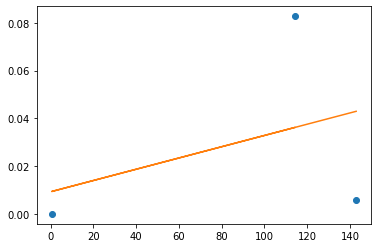

In [20]:
import matplotlib.pyplot as plt
#https://www.kite.com/python/answers/how-to-plot-a-linear-regression-line-on-a-scatter-plot-in-python

temp  = np.array(regression_coef(model, X, y))
a,  c = [], []
for i in range(len(temp)):
    a.append(temp[i][1])
    c.append(temp[i][2])
    
plt.plot(a,c, 'o')

m, b = np.polyfit(a,c,1)
m1 = [i*m for i in a]
plt.plot(a, m1 + b)

In [36]:

price_sum = home['PRICE'].sum()
X = np.array(home['PRICE'])
Y = np.array(home['SQFT'])
denominator = X.dot(X) - X.mean()*price_sum
a = (X.dot(Y) - Y.mean()*summ)/denominator
b = (Y.mean() * X.dot(X) - X.mean() * X.dot(Y))/denominator
print(a,b)

1.1629743511743347 417.92110405968685


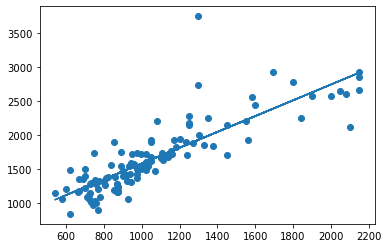

In [37]:
Y_ = a*X + b
plt.scatter(X,Y)
plt.plot(X, Y_)
plt.show()

# Полиномиальная регрессия

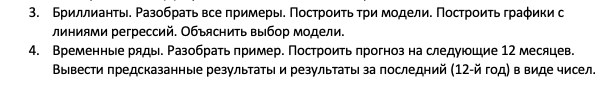

Будем предсказывать цену кольца с бриллиантом от веса бриллианта. Попробуем предсказать результат не только с помощью самой переменной, но и с помощью её степеней. Первая модель будет зависеть только от самой переменной weight, вторая -- от переменной weight^2, а третья -- от двух этих переменных сразу.

В этих случаях, когда мы хотим попробовать в качестве фичей их степени и произведения фич, в sklearn.preprocessing есть класс PolynomialFeatures. Метод fit_transform этого класса сгенерирует из данного множества фич множество одночленов заданной степени. Например, для степени 2 и фич a, b будут сгенерированы фичи [a, b, a^2, b^2, ab], а при указанном параметре include_bias=True ещё и вектор-свободный член из единиц. Для данной задачи, конечно, проще было сгенерить один столбец из квадратов значений колонки weight. Но нам важно ознакомиться с классом PolynomialFeatures для дальнейшего применения.

In [28]:
dia = pd.read_csv('diamond.dat', header=None, sep='\s+', names=['weight', 'price'])
dia.head()

,weight,price
0,0.17,355
1,0.16,328
2,0.17,350
3,0.18,325
4,0.25,642


In [29]:
dia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   weight  48 non-null     float64
 1   price   48 non-null     int64  
dtypes: float64(1), int64(1)
memory usage: 896.0 bytes


Будем предсказывать цену кольца с бриллиантом от веса бриллианта. 
тк планиурем использовать разные степени переменных, используем класс PolynomialFeatures.

Метод fit_transform

In [30]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(
                          # Максимальная степень
                          degree=2,
                          # Не генерировать свободный член
                          include_bias=False)
y =  dia['price']
X0 = poly.fit_transform(dia[['weight']])
X0 = pd.DataFrame(X0, columns=['weight', 'weight^2'])
X0.head()

,weight,weight^2
0,0.17,0.0289
1,0.16,0.0256
2,0.17,0.0289
3,0.18,0.0324
4,0.25,0.0625


In [31]:
X0 = [
    # Одна оригинальная переменная weight
    X0[['weight']],
    # Одна переменная weight^2
    X0[['weight^2']],
    # Две переменных weight и weight^2
    X0.copy()]
models = [LinearRegression() for _ in X0]

In [32]:
for X, model in zip(X0, models):
    model.fit(X, y)
    print(model.score(X, y))
    
# коэффициенты детерминации одинаковы != одинаково полезны

0.978260777986033
0.9703108184171091
0.9789175801893899


In [33]:
regression_coef(models[0], X0[0], y)

,predictor,coef,pvalue
0,intercept,-259.625907,0.0
1,weight,3721.024852,0.0


In [26]:
# temp  = np.array(regression_coef(models[0], X0[0], y))
# a,  c = [], []
# for i in range(len(temp)):
#     a.append(temp[i][1])
#     c.append(temp[i][2])
    
# plt.plot(a, c, 'o')

# m, b = np.polyfit(a,c,1)
# m1 = [i*m for i in a]
# plt.plot(a, m1 + b)

In [64]:
regression_coef(models[1], X0[1], y)

,predictor,coef,pvalue
0,intercept,141.659045,0.0
1,weight^2,7993.108083,0.0


In [70]:
regression_coef(models[2], X0[2], y)

,predictor,coef,pvalue
0,intercept,-174.130082,0.021866
1,weight,2920.130591,0.000077
2,weight^2,1739.901579,0.237265


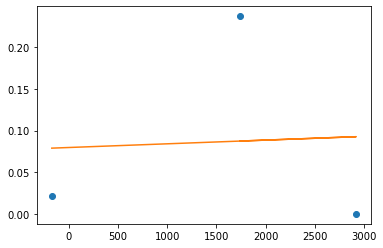

In [72]:
temp  = np.array(regression_coef(models[2], X0[2], y))
a,  c = [], []
for i in range(len(temp)):
    a.append(temp[i][1])
    c.append(temp[i][2])
    
plt.plot(a, c, 'o')

m, b = np.polyfit(a,c,1)
m1 = [i*m for i in a]
plt.plot(a, m1 + b)

In [65]:
import statsmodels.api as sm
X2 = sm.add_constant(X0[2])
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     1045.
Date:                Sun, 04 Oct 2020   Prob (F-statistic):           1.94e-38
Time:                        21:37:20   Log-Likelihood:                -232.47
No. Observations:                  48   AIC:                             470.9
Df Residuals:                      45   BIC:                             476.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -174.1301     74.238     -2.346      0.0

# Прогнозирование временных рядов

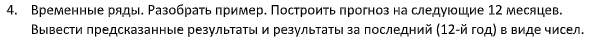

In [92]:
df = pd.read_csv('series_g.csv', sep=';')
df.head()

,date,series_g
0,JAN 1949,112
1,FEB 1949,118
2,MAR 1949,132
3,APR 1949,129
4,MAY 1949,121


In [93]:
df['date'] = pd.to_datetime(df['date'], format='%b %Y')  #сначала месяц потом год

In [94]:
df

,date,series_g
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


In [95]:
print(df['series_g'])
print(np.log10(df['series_g']))

0      112
1      118
2      132
3      129
4      121
      ... 
139    606
140    508
141    461
142    390
143    432
Name: series_g, Length: 144, dtype: int64
0      2.049218
1      2.071882
2      2.120574
3      2.110590
4      2.082785
         ...   
139    2.782473
140    2.705864
141    2.663701
142    2.591065
143    2.635484
Name: series_g, Length: 144, dtype: float64


Построим графики объёма пассажироперевозок и проверим, какой тип тренда (линейный или нет) и какой тип сезонности ( аддитивный или мультипликативный), наблюдается. По первому графику уже прослеживается линейный тренд и мультипликативная сезонность. Но чтобы окончательно убедиться в последнем, добавим график логарифма от этой же величины. После логирафмирования циклы стали одинаковой высоты, а это и говорит о мультипликативном харакрете сезонности.

Text(0, 0.5, 'log10 от тысяч человек')

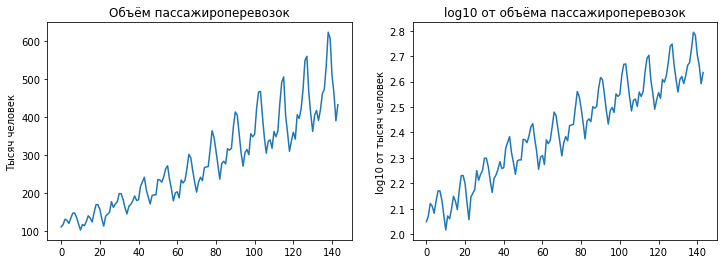

In [96]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(121)
df['series_g'].plot(ax=ax1)
ax1.set_title(u'Объём пассажироперевозок')
ax1.set_ylabel(u'Тысяч человек')

ax2 = fig.add_subplot(122)
pd.Series(np.log10(df['series_g'])).plot(ax=ax2)
ax2.set_title(u'log10 от объёма пассажироперевозок')
ax2.set_ylabel(u'log10 от тысяч человек')

Для удобства дальнейшего использования создадим дополнительно 12 новых месяцев для построения прогноза на них. Для этого создадим эти 12 новых дат с помощью функции ```pd.date_range```. Данный объект будет объектом класса ```DateTimeIndex``` (наследованный от класса ```Index```), и чтобы объединить их с колонкой ```df['date']```, принадлежащей классу ```datetime64```, придётся привести последнюю к классу ```Index```. Объединим два набора дат и сохраним их в объекте ```new_dates```.

Далее создадим фиктивный датафрейм ```df2```, состоящий из одной колонки с этими новыми датами, и приклеим его к исходному датафрейму ```df``` с помозью функции ```pd.merge```. Эта функция склеивает два датасета по указанному набору колонок (параметр ```on```) и по указанному правилу склейки (параметр ```how```). В ```on``` указываем одну общую колонку ```date```, по которой нужно произвести склейку. В ```how``` указываем ```right```, что означает следующее: 
возьми весь правый датасет и приклей к нему левый датасет по условию совпадения значений колонки ```on```, а в случае если для значений из правой колонки ```on``` не найдётся соотвествующих значений в левой колонке ```on```, то тогда приклей ```NaN``` значения. Вообще говоря, опция ```how``` соответствует опциям ```JOIN``` в языке SQL (```LEFT JOIN```, ```RIGHT_JOIN```, ```INNER JOIN```, ```OUTER_JOIN```).

In [97]:
# Создаём последовательсть месяцев. freq='MS' означает первое число каждого месяца из указанного диапазона дат
new_dates = pd.date_range('1961-01-01', '1961-12-01', freq='MS')
# Приводим df['date'] к типу Index, объединяем с 12 месяцами, полученными на предыдущем шаге
new_dates = pd.Index(df['date']) | new_dates
# Создаём датафрейм из одной колонки с расширенным набором дат
df2 = pd.DataFrame({'date': new_dates})
# Объединяем два датафрейма по колонке 'date'.
df = pd.merge(df, df2, on='date', how='right')

In [98]:
df

,date,series_g
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,129.0
4,1949-05-01,121.0
...,...,...
151,1961-08-01,NaN
152,1961-09-01,NaN
153,1961-10-01,NaN
154,1961-11-01,NaN


In [99]:
df['month_num'] = range(1, len(df) + 1)
df['log_y'] = np.log10(df['series_g'])

In [100]:
df

,date,series_g,month_num,log_y
0,1949-01-01,112.0,1,2.049218
1,1949-02-01,118.0,2,2.071882
2,1949-03-01,132.0,3,2.120574
3,1949-04-01,129.0,4,2.110590
4,1949-05-01,121.0,5,2.082785
...,...,...,...,...
151,1961-08-01,NaN,152,NaN
152,1961-09-01,NaN,153,NaN
153,1961-10-01,NaN,154,NaN
154,1961-11-01,NaN,155,NaN


Создадим 12 колонок season_1, season_2, ..., season_12, в которые поместим индикаторы соответствующего месяца. Чтобы достать порядковый номер месяца в каждой строчке, применим последовательно пару методов dt и month к колонке df['date']. Внутри цикла будем проверять, равен ли очередной месяц текущему значению из цикла.

In [102]:
for x in range(1, 13):
    df['season_' + str(x)] = df['date'].dt.month == x

In [103]:
df

,date,series_g,month_num,log_y,season_1,season_2,season_3,season_4,season_5,season_6,season_7,season_8,season_9,season_10,season_11,season_12
0,1949-01-01,112.0,1,2.049218,True,False,False,False,False,False,False,False,False,False,False,False
1,1949-02-01,118.0,2,2.071882,False,True,False,False,False,False,False,False,False,False,False,False
2,1949-03-01,132.0,3,2.120574,False,False,True,False,False,False,False,False,False,False,False,False
3,1949-04-01,129.0,4,2.110590,False,False,False,True,False,False,False,False,False,False,False,False
4,1949-05-01,121.0,5,2.082785,False,False,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,1961-08-01,NaN,152,NaN,False,False,False,False,False,False,False,True,False,False,False,False
152,1961-09-01,NaN,153,NaN,False,False,False,False,False,False,False,False,True,False,False,False
153,1961-10-01,NaN,154,NaN,False,False,False,False,False,False,False,False,False,True,False,False
154,1961-11-01,NaN,155,NaN,False,False,False,False,False,False,False,False,False,False,True,False


In [123]:
#  базовый месяц  - январь

# xrange(2, 13) соответствует всем месяцам с февраля по декабрь
season_columns = ['season_' + str(x) for x in range(2, 13)]

# Создадим объекты матрицу X и вектор y для обучения модели
X = df[['month_num'] + season_columns]
y = df['log_y']

# Оставим только те строчки, у которых известны значения y (с номером < 144)
X1 = X[X.index < 144]
y1 = y[y.index < 144]

In [124]:
model = LinearRegression()
model.fit(X1, y1)

LinearRegression()

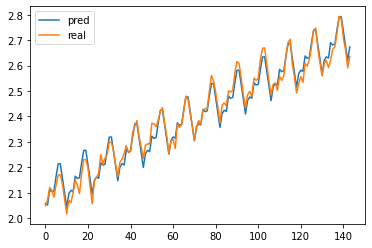

In [125]:
pred = pd.DataFrame({
    'pred': model.predict(X1),
    'real': y1})
pred.plot()

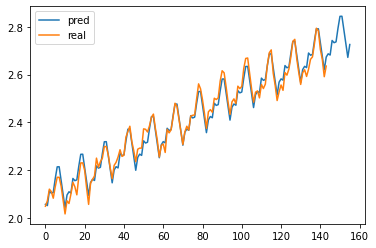

In [127]:
#Теперь построим предсказание для всей матрицы X, включая неизвестные 12 месяцев.
pred = pd.DataFrame({
    'pred': model.predict(X),
    'real': y})
pred.plot()

In [132]:
# вывести предсказанные результаты и резузальтаты за последний (1961) год в виде чисел

In [142]:
# temp_y = np.array(y)
# temp_y = [10**i for i in temp_y]
# print(temp_y)
 
    
temp_x = np.array(model.predict(X))
temp_x = [10**i for i in temp_x]
temp_x = temp_x[144:]
print("Предсказанные результаты за последний год (1961): ",temp_x)

## ?? Реальных результатов за последний год там же Nan стоят

Предсказанные результаты за последний год:  [486.2666107490887, 480.47300064208673, 552.839079457425, 541.2422248306394, 545.4237838910836, 622.5214483655762, 697.7000026118369, 698.2402076908801, 610.3285285834767, 536.9515929907602, 469.7774358113036, 531.7603096719271]


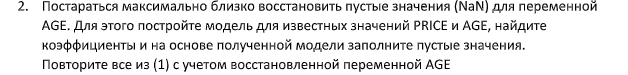

In [327]:
home1 = pd.read_csv('Home_prices.txt', sep="\t", header = 0, index_col=False)

In [328]:
home1

,PRICE,SQFT,AGE,FEATS,NE,CUST,COR,TAX
0,2050,2650,13,7,1,1,0,1639
1,2080,2600,-9999,4,1,1,0,1088
2,2150,2664,6,5,1,1,0,1193
3,2150,2921,3,6,1,1,0,1635
4,1999,2580,4,4,1,1,0,1732
...,...,...,...,...,...,...,...,...
112,872,1229,6,3,0,0,0,721
113,870,1273,4,4,0,0,0,638
114,869,1165,7,4,0,0,0,694
115,766,1200,7,4,0,0,1,634


In [329]:
print('Rows in the dataframe: {0} '.format(len(home1)))
print('Rows without NAN: {0}'.format(len(home1.dropna(how='any'))))

Rows in the dataframe: 117 
Rows without NAN: 117


In [330]:
import collections, numpy
a = np.array(home1['AGE'].isnull())
print(collections.Counter(a))
# предполагаю, что значения возраста -999 не котируется 

b = np.array(home1['AGE'])
print(collections.Counter(b))
# -999 - 49

Counter({False: 117})
Counter({-9999: 49, 4: 8, 6: 7, 7: 6, 15: 5, 5: 4, 13: 3, 16: 3, 17: 3, 3: 2, 1: 2, 8: 2, 14: 2, 28: 2, 25: 2, 40: 2, 2: 1, 18: 1, 53: 1, 30: 1, 41: 1, 46: 1, 43: 1, 23: 1, 26: 1, 34: 1, 20: 1, 19: 1, 22: 1, 45: 1, 9: 1})


In [331]:
home1 = home1.replace(-9999, np.nan)

In [332]:
home1.apply(lambda x: sum(x.isnull()), axis=0)

PRICE     0
SQFT      0
AGE      49
FEATS     0
NE        0
CUST      0
COR       0
TAX      10
dtype: int64

In [333]:
#del home['AGE']

# заменяем пропуски на среднее значение
home1['TAX'] = home1['TAX'].fillna(home['TAX'].mean())

In [334]:
home1.apply(lambda x: sum(x.isnull()), axis=0)

PRICE     0
SQFT      0
AGE      49
FEATS     0
NE        0
CUST      0
COR       0
TAX       0
dtype: int64

In [311]:
# null_age = np.array(home1['AGE'].isnull())
# #null_age_index = null_age_index[i for i in range(len(null_age_index)) if null_age_index[i]==True]
# null_age_ind = []
# for i in range(len(null_age)):
#     if null_age[i]==True:
#         null_age_ind.append(i)


In [335]:
home1

,PRICE,SQFT,AGE,FEATS,NE,CUST,COR,TAX
0,2050,2650,13.0,7,1,1,0,1639.0
1,2080,2600,NaN,4,1,1,0,1088.0
2,2150,2664,6.0,5,1,1,0,1193.0
3,2150,2921,3.0,6,1,1,0,1635.0
4,1999,2580,4.0,4,1,1,0,1732.0
...,...,...,...,...,...,...,...,...
112,872,1229,6.0,3,0,0,0,721.0
113,870,1273,4.0,4,0,0,0,638.0
114,869,1165,7.0,4,0,0,0,694.0
115,766,1200,7.0,4,0,0,1,634.0


In [336]:
#функция которая заполняет колонны с пустыми значениями (берет рандомное значение из этой же колонны)
def fill_random(df, feature):

    number_missing = df[feature].isnull().sum()
    observed_values = df.loc[df[feature].notnull(), feature]
    df.loc[df[feature].isnull(), feature + '_imputed'] = np.random.choice(observed_values, number_missing, replace = True)

    return df

In [346]:
missing_columns = ["AGE"]
for feature in missing_columns:
    home1[feature + '_imputed'] = home1[feature]
    home1 = fill_random(home1, feature)

In [347]:
home1

,PRICE,SQFT,AGE,FEATS,NE,CUST,COR,TAX,AGE_imputed
0,2050,2650,13.0,7,1,1,0,1639.0,13.0
1,2080,2600,NaN,4,1,1,0,1088.0,16.0
2,2150,2664,6.0,5,1,1,0,1193.0,6.0
3,2150,2921,3.0,6,1,1,0,1635.0,3.0
4,1999,2580,4.0,4,1,1,0,1732.0,4.0
...,...,...,...,...,...,...,...,...,...
112,872,1229,6.0,3,0,0,0,721.0,6.0
113,870,1273,4.0,4,0,0,0,638.0,4.0
114,869,1165,7.0,4,0,0,0,694.0,7.0
115,766,1200,7.0,4,0,0,1,634.0,7.0


In [348]:
home1['AGE_imputed']


0      13.0
1      16.0
2       6.0
3       3.0
4       4.0
       ... 
112     6.0
113     4.0
114     7.0
115     7.0
116     4.0
Name: AGE_imputed, Length: 117, dtype: float64

In [356]:
deter_data = pd.DataFrame(columns = ["Deterministic" + name for name in missing_columns])

for feature in missing_columns:

    deter_data["Deterministic" + feature] = home1[feature + "_imputed"]
    parameters = list(set(home1.columns) - set(missing_columns) - {feature + '_imputed'})

    #Linear Regression model to predict missing data
    model = linear_model.LinearRegression()
    model.fit(X = home1[parameters], y = home1[feature + '_imputed'])
    deter_data.loc[home1[feature].isnull(), "Deterministic" + feature] = model.predict(home1[parameters])[home1[feature].isnull()]

In [357]:
deter_data

,DeterministicAGE
0,13.00000
1,15.87965
2,6.00000
3,3.00000
4,4.00000
...,...
112,6.00000
113,4.00000
114,7.00000
115,7.00000


In [358]:
# теперь заменяем этот столбец на столбец AGE в исходном датасете

In [359]:
home1["AGE"]= deter_data['DeterministicAGE']

In [360]:
home1

,PRICE,SQFT,AGE,FEATS,NE,CUST,COR,TAX,AGE_imputed
0,2050,2650,13.00000,7,1,1,0,1639.0,13.0
1,2080,2600,15.87965,4,1,1,0,1088.0,16.0
2,2150,2664,6.00000,5,1,1,0,1193.0,6.0
3,2150,2921,3.00000,6,1,1,0,1635.0,3.0
4,1999,2580,4.00000,4,1,1,0,1732.0,4.0
...,...,...,...,...,...,...,...,...,...
112,872,1229,6.00000,3,0,0,0,721.0,6.0
113,870,1273,4.00000,4,0,0,0,638.0,4.0
114,869,1165,7.00000,4,0,0,0,694.0,7.0
115,766,1200,7.00000,4,0,0,1,634.0,7.0


In [362]:
X = home1.drop('PRICE', axis=1)
y = home1['PRICE']
model = LinearRegression()
model.fit(X, y)
print('R^2: {0}'.format(model.score(X, y)))

coef = pd.DataFrame(zip(['intercept'] + X.columns.tolist(), [model.intercept_] + model.coef_.tolist()),
                    columns=['predictor', 'coef'])
print(coef)

R^2: 0.8033834885170167
     predictor        coef
0    intercept  102.691979
1         SQFT    0.307409
2          AGE   -0.983896
3        FEATS   11.563466
4           NE   15.857347
5         CUST  134.301262
6          COR  -62.805488
7          TAX    0.507905
8  AGE_imputed   -0.461065


In [363]:
regression_coef(model, X, y)

,predictor,coef,pvalue
0,intercept,102.691979,0.142621
1,SQFT,0.307409,0.000009
2,AGE,-0.983896,0.737778
3,FEATS,11.563466,0.377961
4,NE,15.857347,0.675012
5,CUST,134.301262,0.003378
6,COR,-62.805488,0.138849
7,TAX,0.507905,0.000049
8,AGE_imputed,-0.461065,0.812801


без восстановленного AGE 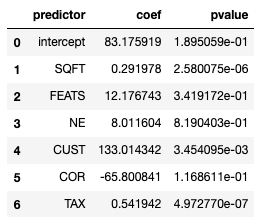

In [366]:
del home1['AGE_imputed']

In [367]:
home1.corr()

,PRICE,SQFT,AGE,FEATS,NE,CUST,COR,TAX
PRICE,1.000000,0.844795,-0.134744,0.420272,0.167840,0.555292,-0.079293,0.844889
SQFT,0.844795,1.000000,0.012801,0.394925,0.145030,0.520102,0.040528,0.832674
AGE,-0.134744,0.012801,1.000000,-0.121558,0.216048,0.011235,0.144315,-0.241877
FEATS,0.420272,0.394925,-0.121558,1.000000,0.190016,0.241964,-0.041547,0.419473
NE,0.167840,0.145030,0.216048,0.190016,1.000000,0.043033,-0.077336,0.189230
CUST,0.555292,0.520102,0.011235,0.241964,0.043033,1.000000,-0.003994,0.444906
COR,-0.079293,0.040528,0.144315,-0.041547,-0.077336,-0.003994,1.000000,-0.058329
TAX,0.844889,0.832674,-0.241877,0.419473,0.189230,0.444906,-0.058329,1.000000
